In [35]:
# !pip install shap

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   ------ --------------------------------- 71.7/456.1 kB 2.0 MB/s eta 0:00:01
   ---------------------------------- ----- 389.1/456.1 kB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 4.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np 
import pandas as pd 

from sklearn.utils import resample # équilibrage de classes

# Préparation des données pour entrainement
from sklearn.model_selection import train_test_split

# Paramètres du modèle
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# sauvegarde des hyperparamètres
import pickle

# Explicabilité
import shap

# fonctions utiles

In [2]:
def load_data(filepath, drop_columns=None):
    """Charge les données depuis un fichier CSV et supprime les colonnes indésirées."""
    df = pd.read_csv(filepath)
    if drop_columns is not None:
        df = df.drop(columns=drop_columns)
    return df

def sort_dataset_by_patient_and_hour(df, patient_id_column='Patient_ID', hour_column='Hour'):
    """
    Trie le DataFrame en fonction des colonnes spécifiées pour Patient_ID et Hour, 
    assurant que les données sont triées d'abord par patient, puis par heure pour chaque patient.

    Args:
    df (DataFrame): Le DataFrame à trier.
    patient_id_column (str): Nom de la colonne contenant les identifiants des patients.
    hour_column (str): Nom de la colonne contenant les heures des prises de mesures.

    Returns:
    DataFrame: Un DataFrame trié selon les identifiants des patients et les heures.
    """
    sorted_df = df.sort_values(by=[patient_id_column, hour_column])
    return sorted_df


def aggregate_sepsis_label(df, patient_id_column='Patient_ID', sepsis_label_column='SepsisLabel'):
    """
    Agrège les données pour chaque patient pour déterminer si le patient a eu un sepsis
    à un moment quelconque et ajoute cette information dans une nouvelle colonne.

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    patient_id_column (str): Le nom de la colonne contenant les identifiants des patients.
    sepsis_label_column (str): Le nom de la colonne contenant les étiquettes de sepsis.

    Returns:
    DataFrame: Un DataFrame enrichi avec une colonne indiquant si le patient a eu un sepsis.
    """
    # Aggrégation des données par patient avec le maximum de SepsisLabel
    aggregated_df = df.groupby(patient_id_column)[sepsis_label_column].max().reset_index()

    # Renommer la colonne pour clarifier qu'il s'agit du résultat de l'aggrégation
    aggregated_df = aggregated_df.rename(columns={sepsis_label_column: 'will_have_sepsis'})

    # Joindre avec les données originales pour obtenir un DataFrame complet par patient
    aggregated_full_df = df.merge(aggregated_df, on=patient_id_column)

    return aggregated_full_df


def display_basic_info(df):
    """Affiche les informations de base sur le DataFrame, y compris sa forme, ses colonnes,
    un résumé descriptif, les valeurs manquantes par colonne et les premières lignes."""
    
    print("Shape of the DataFrame:", df.shape)
    print('\nNumbre of unique patients :', df['Patient_ID'].nunique())
    print("\nLignes classes counts : ", df['SepsisLabel'].value_counts())
    if 'will_have_sepsis' in df.columns:
        print('\nClasses counts : ', df['will_have_sepsis'].value_counts())
    print("\nColumns in the DataFrame:", df.columns)
    print("\nData Types:\n", df.dtypes)
    display("Descriptive Statistics:", df.describe())
    print("\nMissing Values Per Column:\n", df.isna().sum())
    display("First 5 Rows of the DataFrame:", df.head())
    
    


def clean_data(df, interest_columns=None, missing_value_threshold=0.3):
    """Nettoie le DataFrame en supprimant les lignes avec trop de valeurs manquantes.
    Si 'interest_columns' n'est pas spécifié, toutes les colonnes sont prises en compte."""
    
    if interest_columns is None:
        interest_columns = df.columns.tolist()
    seuil = missing_value_threshold * len(interest_columns)
    cleaned_df = df.dropna(subset=interest_columns, thresh=len(interest_columns) - seuil)
    return cleaned_df


def balance_classes(df, target_column, method='undersample', random_state=123):
    """
    Équilibre les classes dans un DataFrame en sous-échantillonnant la classe majoritaire ou 
    en sur-échantillonnant la classe minoritaire selon le paramètre 'method'.

    Args:
    df (DataFrame): Le DataFrame à équilibrer.
    target_column (str): Nom de la colonne contenant les étiquettes de classe.
    method (str): Méthode d'équilibrage, 'undersample' pour sous-échantillonnage ou 'oversample' pour sur-échantillonnage.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    DataFrame: Un DataFrame où les classes sont équilibrées.
    """
    # Identifier les classes majoritaire et minoritaire
    class_counts = df[target_column].value_counts()
    major_class_label = class_counts.idxmax()
    minor_class_label = class_counts.idxmin()

    major_class = df[df[target_column] == major_class_label]
    minor_class = df[df[target_column] == minor_class_label]

    if method == 'undersample':
        # Sous-échantillonnage de la classe majoritaire
        resampled_major_class = resample(major_class,
                                         replace=False,
                                         n_samples=len(minor_class),
                                         random_state=random_state)
        balanced_df = pd.concat([resampled_major_class, minor_class])
    elif method == 'oversample':
        # Sur-échantillonnage de la classe minoritaire
        resampled_minor_class = resample(minor_class,
                                         replace=True,
                                         n_samples=len(major_class),
                                         random_state=random_state)
        balanced_df = pd.concat([major_class, resampled_minor_class])

    return balanced_df


# Chargement des données

In [3]:
file_path = 'Dataset.csv'
drop_columns = ['Unnamed: 0']
df = load_data(file_path, drop_columns)

# Exploration des données

In [17]:
# Affichage des informations de bases
display_basic_info(df)

Shape of the DataFrame: (1552210, 43)

Numbre of unique patients : 40336

Lignes classes counts :  SepsisLabel
0    1524294
1      27916
Name: count, dtype: int64

Columns in the DataFrame: Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float6

'Descriptive Statistics:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
count,1.552210e+06,1.398811e+06,1.349474e+06,525226.000000,1.325945e+06,1.358940e+06,1.065656e+06,1.313875e+06,57636.000000,84145.000000,...,10242.000000,92209.000000,1.552210e+06,1.552210e+06,940250.000000,940250.000000,1.552202e+06,1.552210e+06,1.552210e+06,1.552210e+06
mean,2.549274e+01,8.458144e+01,9.719395e+01,36.977228,1.237505e+02,8.240010e+01,6.383056e+01,1.872650e+01,32.957657,-0.689919,...,287.385706,196.013911,6.200947e+01,5.592690e-01,0.496571,0.503429,-5.612512e+01,2.699499e+01,1.798468e-02,5.920148e+04
std,2.888256e+01,1.732524e+01,2.936924e+00,0.770014,2.323156e+01,1.634175e+01,1.395601e+01,5.098194e+00,7.951662,4.294297,...,153.002908,103.635366,1.638622e+01,4.964749e-01,0.499989,0.499989,1.622569e+02,2.900542e+01,1.328956e-01,5.024819e+04
min,0.000000e+00,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,2.000000e+01,1.000000e+00,10.000000,-32.000000,...,34.000000,1.000000,1.400000e+01,0.000000e+00,0.000000,0.000000,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00
25%,9.000000e+00,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,5.400000e+01,1.500000e+01,28.000000,-3.000000,...,184.000000,126.000000,5.168000e+01,0.000000e+00,0.000000,0.000000,-4.705000e+01,1.100000e+01,0.000000e+00,9.990000e+03
50%,1.900000e+01,8.350000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,6.200000e+01,1.800000e+01,33.000000,0.000000,...,250.000000,181.000000,6.400000e+01,1.000000e+00,0.000000,1.000000,-6.030000e+00,2.100000e+01,0.000000e+00,1.996500e+04
75%,3.300000e+01,9.550000e+01,9.950000e+01,37.500000,1.380000e+02,9.200000e+01,7.200000e+01,2.150000e+01,38.000000,1.000000,...,349.000000,244.000000,7.400000e+01,1.000000e+00,1.000000,1.000000,-4.000000e-02,3.400000e+01,0.000000e+00,1.098780e+05
max,3.350000e+02,2.800000e+02,1.000000e+02,50.000000,3.000000e+02,3.000000e+02,3.000000e+02,1.000000e+02,100.000000,100.000000,...,1760.000000,2322.000000,1.000000e+02,1.000000e+00,1.000000,1.000000,2.399000e+01,3.360000e+02,1.000000e+00,1.200000e+05



Missing Values Per Column:
 Hour                      0
HR                   153399
O2Sat                202736
Temp                1026984
SBP                  226265
MAP                  193270
DBP                  486554
Resp                 238335
EtCO2               1494574
BaseExcess          1468065
HCO3                1487182
FiO2                1422845
pH                  1444637
PaCO2               1465909
SaO2                1498649
AST                 1527027
BUN                 1445642
Alkalinephos        1527269
Calcium             1460879
Chloride            1481744
Creatinine          1457594
Bilirubin_direct    1549220
Glucose             1286694
Lactate             1510764
Magnesium           1454259
Phosphate           1489909
Potassium           1407685
Bilirubin_total     1529069
TroponinI           1537429
Hct                 1414777
Hgb                 1437619
PTT                 1506511
WBC                 1452763
Fibrinogen          1541968
Platelets          

'First 5 Rows of the DataFrame:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
132940,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0,1
132941,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0,1
132942,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0,1
132943,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0,1
132944,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0,1


In [18]:
# Trie par patient and hour
df = sort_dataset_by_patient_and_hour(df)

# Aggrégation des données par patient avec le maximum de SepsisLabel
aggregate_df = aggregate_sepsis_label(df)

# Affichage des informations de bases
display_basic_info(aggregate_df)

Shape of the DataFrame: (1552210, 44)

Numbre of unique patients : 40336

Lignes classes counts :  SepsisLabel
0    1524294
1      27916
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    1379800
1     172410
Name: count, dtype: int64

Columns in the DataFrame: Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 flo

'Descriptive Statistics:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
count,1.552210e+06,1.398811e+06,1.349474e+06,525226.000000,1.325945e+06,1.358940e+06,1.065656e+06,1.313875e+06,57636.000000,84145.000000,...,92209.000000,1.552210e+06,1.552210e+06,940250.000000,940250.000000,1.552202e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06
mean,2.549274e+01,8.458144e+01,9.719395e+01,36.977228,1.237505e+02,8.240010e+01,6.383056e+01,1.872650e+01,32.957657,-0.689919,...,196.013911,6.200947e+01,5.592690e-01,0.496571,0.503429,-5.612512e+01,2.699499e+01,1.798468e-02,5.920148e+04,1.110739e-01
std,2.888256e+01,1.732524e+01,2.936924e+00,0.770014,2.323156e+01,1.634175e+01,1.395601e+01,5.098194e+00,7.951662,4.294297,...,103.635366,1.638622e+01,4.964749e-01,0.499989,0.499989,1.622569e+02,2.900542e+01,1.328956e-01,5.024819e+04,3.142237e-01
min,0.000000e+00,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,2.000000e+01,1.000000e+00,10.000000,-32.000000,...,1.000000,1.400000e+01,0.000000e+00,0.000000,0.000000,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,9.000000e+00,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,5.400000e+01,1.500000e+01,28.000000,-3.000000,...,126.000000,5.168000e+01,0.000000e+00,0.000000,0.000000,-4.705000e+01,1.100000e+01,0.000000e+00,9.990000e+03,0.000000e+00
50%,1.900000e+01,8.350000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,6.200000e+01,1.800000e+01,33.000000,0.000000,...,181.000000,6.400000e+01,1.000000e+00,0.000000,1.000000,-6.030000e+00,2.100000e+01,0.000000e+00,1.996500e+04,0.000000e+00
75%,3.300000e+01,9.550000e+01,9.950000e+01,37.500000,1.380000e+02,9.200000e+01,7.200000e+01,2.150000e+01,38.000000,1.000000,...,244.000000,7.400000e+01,1.000000e+00,1.000000,1.000000,-4.000000e-02,3.400000e+01,0.000000e+00,1.098780e+05,0.000000e+00
max,3.350000e+02,2.800000e+02,1.000000e+02,50.000000,3.000000e+02,3.000000e+02,3.000000e+02,1.000000e+02,100.000000,100.000000,...,2322.000000,1.000000e+02,1.000000e+00,1.000000,1.000000,2.399000e+01,3.360000e+02,1.000000e+00,1.200000e+05,1.000000e+00



Missing Values Per Column:
 Hour                      0
HR                   153399
O2Sat                202736
Temp                1026984
SBP                  226265
MAP                  193270
DBP                  486554
Resp                 238335
EtCO2               1494574
BaseExcess          1468065
HCO3                1487182
FiO2                1422845
pH                  1444637
PaCO2               1465909
SaO2                1498649
AST                 1527027
BUN                 1445642
Alkalinephos        1527269
Calcium             1460879
Chloride            1481744
Creatinine          1457594
Bilirubin_direct    1549220
Glucose             1286694
Lactate             1510764
Magnesium           1454259
Phosphate           1489909
Potassium           1407685
Bilirubin_total     1529069
TroponinI           1537429
Hct                 1414777
Hgb                 1437619
PTT                 1506511
WBC                 1452763
Fibrinogen          1541968
Platelets          

'First 5 Rows of the DataFrame:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,1,0,1,0
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,2,0,1,0
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,3,0,1,0
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,NaN,83.14,0,NaN,NaN,-0.03,4,0,1,0
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,5,0,1,0


In [22]:
# à ne pas exécuter

# suppression des lignes ayant plus de 30% de nan pour sous ensemble 'interest_columns'
interest_columns = ['HR', 'Temp', 'WBC', 'SBP', 'DBP', 'MAP', 'Creatinine', 'BUN', 'Platelets']

cleaned_df = clean_data(df)

display_basic_info(cleaned_df)

Shape of the DataFrame: (15817, 43)

Classes counts :  SepsisLabel
0    15223
1      594
Name: count, dtype: int64

Columns in the DataFrame: Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3                float64
FiO2              

'Descriptive Statistics:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
count,15817.000000,15786.000000,15525.000000,9458.000000,15627.000000,15737.000000,14061.000000,15242.000000,1119.000000,9710.000000,...,3412.000000,15554.000000,15817.000000,15817.000000,10666.000000,10666.000000,15817.000000,15817.000000,15817.000000,15817.000000
mean,21.140482,87.282465,97.742319,36.795164,120.449959,80.697557,61.505932,18.015123,31.152368,-0.485113,...,282.530012,178.651167,61.781082,0.603085,0.389274,0.610726,-68.246227,23.194032,0.037555,30276.197193
std,29.795367,17.802472,3.411202,1.007445,22.899831,17.093640,13.506104,5.547441,8.243622,4.459893,...,150.609869,106.318203,15.656783,0.489274,0.487609,0.487609,220.206753,29.921113,0.190122,40350.775087
min,0.000000,20.000000,27.000000,26.670000,34.000000,20.000000,22.000000,1.000000,10.000000,-32.000000,...,35.000000,2.000000,14.000000,0.000000,0.000000,0.000000,-5366.860000,2.000000,0.000000,3.000000
25%,4.000000,75.000000,97.000000,36.200000,104.000000,69.000000,52.000000,14.000000,26.000000,-2.500000,...,185.000000,106.000000,51.760000,0.000000,0.000000,0.000000,-50.380000,6.000000,0.000000,6442.000000
50%,12.000000,86.000000,99.000000,36.890000,117.000000,78.000000,60.000000,17.000000,31.500000,0.000000,...,246.000000,159.000000,63.360000,1.000000,0.000000,1.000000,-6.320000,15.000000,0.000000,13030.000000
75%,29.000000,98.000000,100.000000,37.440000,134.000000,89.000000,69.000000,21.000000,37.000000,2.000000,...,334.000000,224.000000,73.850000,1.000000,1.000000,1.000000,-0.030000,31.000000,0.000000,19110.000000
max,333.000000,223.000000,100.000000,41.970000,281.000000,291.000000,281.000000,53.000000,83.000000,36.000000,...,1383.000000,1592.000000,100.000000,1.000000,1.000000,1.000000,23.990000,335.000000,1.000000,119994.000000



Missing Values Per Column:
 Hour                    0
HR                     31
O2Sat                 292
Temp                 6359
SBP                   190
MAP                    80
DBP                  1756
Resp                  575
EtCO2               14698
BaseExcess           6107
HCO3                 3226
FiO2                 8548
pH                   4378
PaCO2                4716
SaO2                10514
AST                  8053
BUN                    62
Alkalinephos         8057
Calcium              2965
Chloride             2738
Creatinine            166
Bilirubin_direct    14652
Glucose               117
Lactate              9688
Magnesium            1684
Phosphate            3225
Potassium             143
Bilirubin_total      8094
TroponinI           14719
Hct                    86
Hgb                   250
PTT                  3926
WBC                   273
Fibrinogen          12405
Platelets             263
Age                     0
Gender                  0
Unit1    

'First 5 Rows of the DataFrame:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
108,13,128.0,98.0,NaN,141.0,94.00,72.0,NaN,NaN,-11.0,...,NaN,461.0,58.18,0,1.0,0.0,-2.43,14,0,9891
132,1,117.0,100.0,NaN,163.0,110.33,NaN,19.0,NaN,NaN,...,NaN,194.0,67.00,1,1.0,0.0,-0.01,2,0,8065
187,10,94.0,100.0,37.1,121.0,83.00,53.0,12.0,NaN,-2.0,...,NaN,155.0,75.52,1,0.0,1.0,-42.26,16,0,3516
254,19,65.0,100.0,NaN,96.0,69.00,68.0,20.0,NaN,0.0,...,NaN,138.0,59.28,1,NaN,NaN,-0.02,22,0,11093
282,47,83.0,100.0,NaN,83.0,66.00,53.0,20.0,NaN,0.0,...,NaN,151.0,59.28,1,NaN,NaN,-0.02,50,0,11093


In [11]:
# Équilibrage de classes

cleaned_df_undersample = balance_classes(aggregate_df, 'will_have_sepsis')

# Affichage des informations après équilibrage 
display_basic_info(cleaned_df_undersample)

Shape of the DataFrame: (344820, 44)

Lignes classes counts :  SepsisLabel
0    316904
1     27916
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    172410
1    172410
Name: count, dtype: int64

Columns in the DataFrame: Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp   

'Descriptive Statistics:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
count,344820.000000,314950.000000,305660.000000,119057.000000,295652.000000,307610.000000,245930.000000,295416.000000,23015.000000,23854.000000,...,21377.000000,344820.000000,344820.000000,194137.000000,194137.000000,344819.000000,344820.000000,344820.000000,344820.000000,344820.000000
mean,40.019613,86.142503,97.235679,37.038658,123.929602,82.186536,63.327727,19.203141,32.842755,-0.487400,...,191.620515,62.109879,0.572333,0.507708,0.492292,-66.633661,41.587478,0.080958,54984.826573,0.500000
std,46.245416,17.949886,2.987687,0.835501,23.729613,16.290120,13.880099,5.486377,7.653652,4.435242,...,107.018883,16.292462,0.494741,0.499942,0.499942,191.770907,46.370726,0.272771,49979.698492,0.500001
min,0.000000,20.000000,20.000000,26.670000,21.000000,20.000000,20.000000,1.000000,10.000000,-28.000000,...,1.000000,14.000000,0.000000,0.000000,0.000000,-5366.860000,1.000000,0.000000,1.000000,0.000000
25%,11.000000,73.000000,96.000000,36.500000,106.000000,71.000000,54.000000,16.000000,28.000000,-3.000000,...,117.000000,52.000000,0.000000,0.000000,0.000000,-53.355000,13.000000,0.000000,9313.000000,0.000000
50%,25.000000,85.000000,98.000000,37.000000,121.000000,80.000000,62.000000,18.500000,33.000000,0.000000,...,176.000000,64.000000,1.000000,1.000000,0.000000,-5.180000,27.000000,0.000000,18641.000000,0.500000
75%,47.000000,98.000000,100.000000,37.600000,139.000000,92.000000,71.000000,22.000000,37.500000,2.000000,...,242.000000,74.000000,1.000000,1.000000,1.000000,-0.030000,49.000000,0.000000,108899.000000,1.000000
max,335.000000,223.000000,100.000000,41.800000,299.000000,298.000000,298.000000,100.000000,100.000000,22.000000,...,1191.000000,100.000000,1.000000,1.000000,1.000000,23.990000,336.000000,1.000000,120000.000000,1.000000



Missing Values Per Column:
 Hour                     0
HR                   29870
O2Sat                39160
Temp                225763
SBP                  49168
MAP                  37210
DBP                  98890
Resp                 49404
EtCO2               321805
BaseExcess          320966
HCO3                328095
FiO2                303261
pH                  314592
PaCO2               320181
SaO2                330770
AST                 338245
BUN                 319392
Alkalinephos        338275
Calcium             322284
Chloride            326499
Creatinine          322736
Bilirubin_direct    344011
Glucose             284509
Lactate             331507
Magnesium           320601
Phosphate           328908
Potassium           309430
Bilirubin_total     338949
TroponinI           341905
Hct                 312873
Hgb                 317976
PTT                 333183
WBC                 321334
Fibrinogen          342017
Platelets           323443
Age                      0

'First 5 Rows of the DataFrame:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
934558,26,65.0,99.0,NaN,98.0,65.0,54.0,16.0,NaN,NaN,...,NaN,57.00,0,1.0,0.0,-2.03,27,0,103826,0
389407,16,85.0,95.0,37.3,132.0,72.0,41.0,27.0,NaN,NaN,...,NaN,72.89,0,0.0,1.0,-185.19,19,0,10026,0
577714,38,73.0,97.0,NaN,101.0,52.0,NaN,14.0,NaN,NaN,...,NaN,80.33,0,0.0,1.0,-2.84,39,0,14912,0
311438,33,81.0,93.0,NaN,102.0,68.0,51.0,17.0,NaN,NaN,...,160.0,62.20,1,0.0,1.0,-18.17,37,0,8036,0
657486,22,75.0,96.0,NaN,129.0,68.0,54.0,12.0,NaN,-4.0,...,NaN,83.50,1,0.0,1.0,-3.53,23,0,16967,0


# Entrainement du modèle sur les données complètes et brutes

In [7]:
# Découpage de l'ensemble d'entrainement et de test
def prepare_train_test(df, label_column, test_size=0.2, random_state=None, stratify=True):
    """
    Prépare les ensembles d'entraînement et de test à partir d'un DataFrame donné.

    Args:
    df (DataFrame): Le DataFrame à partir duquel les ensembles doivent être créés.
    label_column (str): Le nom de la colonne qui contient les étiquettes cibles.
    test_size (float): La proportion du dataset à inclure dans l'ensemble de test.
    random_state (int): Contrôle la reproductibilité des résultats en fixant un seed pour le générateur aléatoire.
    stratify (bool): Si True, les données sont divisées de façon à préserver le même pourcentage pour chaque classe cible dans les ensembles de train et de test.

    Returns:
    tuple: Contient les ensembles X_train, X_test, y_train, y_test.
    """
    # Séparation des features et des étiquettes
    X = df.drop(columns=[label_column])
    y = df[label_column]

    # Stratification optionnelle basée sur les étiquettes
    stratify_param = y if stratify else None

    # Répartition des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        stratify=stratify_param, random_state=random_state)
    
    # Affichage des dimensions des ensembles pour vérification
    print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)

    return X_train, X_test, y_train, y_test


def objective(trial, X, y, cv=7):
    """
    Fonction objectif pour l'optimisation d'hyperparamètres avec Optuna.

    Args:
    trial (optuna.trial): Un essai de Optuna pour suggérer les hyperparamètres.
    X (DataFrame): Features du dataset.
    y (Series): Étiquettes cibles du dataset.
    cv (int): Nombre de plis pour la validation croisée.

    Returns:
    float: La moyenne des scores de validation croisée pour les hyperparamètres suggérés.
    """
    # Hyperparamètres suggérés par Optuna
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 2, 15)
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_uniform('gamma', 0.01, 5)
    subsample = trial.suggest_uniform('subsample', 0.01, 1)
    
    # Création et évaluation du modèle
    clf = XGBClassifier(learning_rate=learning_rate,
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        min_child_weight=min_child_weight,
                        gamma=gamma,
                        subsample=subsample,
                        use_label_encoder=False,
                        eval_metric='logloss')
    
    # Calcul du score moyen sur les plis de validation croisée
    score = cross_val_score(clf, X, y, cv=cv)
    
    return np.mean(score)


def perform_hyperparameter_optimization(X, y, objective, n_trials=50, random_state=42):
    """
    Crée une étude Optuna pour optimiser les hyperparamètres d'un modèle de machine learning.

    Args:
    X (DataFrame): Les features d'entrée pour le modèle.
    y (Series): Les étiquettes cibles.
    objective (function): La fonction objective pour Optuna.
    n_trials (int): Le nombre de tentatives d'optimisation.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    dict: Meilleurs hyperparamètres trouvés par l'étude Optuna.
    """
    # Création d'un objet study d'Optuna
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))
    
    # Lancement de l'optimisation
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    # Retourne les meilleurs paramètres trouvés
    return study.best_params, study

# sauvegarde des meilleurs hyperparamètres
def save_study(study, filename):
    with open(filename, 'wb') as f:
        pickle.dump(study, f)

# chargement des meilleurs hyperparamètres
def load_study(filename):
    with open(filename, 'rb') as f:
        study = pickle.load(f)
    return study

def train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path):
    """
    Crée, entraîne et sauvegarde un modèle XGBoost avec des paramètres spécifiés.

    Args:
    X_train (DataFrame): Les features d'entraînement.
    y_train (Series): Les étiquettes cibles d'entraînement.
    best_params (dict): Dictionnaire contenant les meilleurs paramètres pour le modèle.
    model_path (str): Chemin du fichier où le modèle sera sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost entraîné.
    """
    xgbc = XGBClassifier(
        n_jobs=-1,  # Utiliser tous les processeurs disponible
        tree_method='hist',  # Utiliser 'hist' pour accélérer l'entraînement
        subsample=0.8,       # Sous-échantillonnage pour réduire le temps d'entraînement
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        #subsample=best_params['subsample'],
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Entraînement du modèle
    xgbc.fit(X_train, y_train)

    # Sauvegarde du modèle
    with open(model_path, 'wb') as file:
        pickle.dump(xgbc, file)

    return xgbc


def predict_and_evaluate(model, X_test, y_test):
    """
    Fait des prédictions avec un modèle donné et évalue les résultats.

    Args:
    model (XGBClassifier): Le modèle entraîné à utiliser pour les prédictions.
    X_test (DataFrame): Les features de test.
    y_test (Series): Les étiquettes cibles de test.

    Returns:
    str: Un rapport d'évaluation imprimable.
    """
    # Prédiction avec le modèle
    y_predicted = model.predict(X_test)

    # Génération du rapport d'évaluation
    evaluation_report = classification_report(y_test, y_predicted)

    return evaluation_report


def explain_model_predictions_with_shap(model, X_train, X_test):
    """
    Explique les prédictions d'un modèle XGBoost en utilisant SHAP.

    Args:
    model (XGBClassifier): Le modèle entraîné.
    X_train (DataFrame): Les données d'entraînement.
    X_test (DataFrame): Les données de test pour lesquelles les explications sont générées.

    Returns:
    None: Affiche les graphiques SHAP.
    """
    # Création d'un explainer SHAP
    explainer = shap.Explainer(model, X_train)

    # Calcul des valeurs SHAP
    shap_values = explainer(X_test)

    # Affichage du summary plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")


In [25]:
# Création des ensembles d'entrainement et de test
df_final = cleaned_df_undersample.drop(columns = ['will_have_sepsis'])
X_train, X_test, y_train, y_test = prepare_train_test(df_final, 'SepsisLabel')

X_train: (275856, 42) X_test: (68964, 42) y_train: (275856,) y_test: (68964,)


In [ ]:
# Calcule des meilleurs hyperparamètres
best_params, study = perform_hyperparameter_optimization(X_train, y_train, objective, n_trials=100)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_v1.pkl'
save_study(study, study_filename)

[I 2024-07-19 13:52:21,796] A new study created in memory with name: no-name-568eea25-cd55-4b29-8f77-90f23010806c
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-07-19 14:12:22,897] Trial 6 finished with value: 0.9820087165643684 and parameters: {'learning_rate': 0.31156763148163696, 'max_depth': 3, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 0.6189707918754463, 'subsample': 0.5002251410101575}. Best is trial 1 with value: 0.9831272830512379.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:52

[I 2024-07-19 14:33:47,414] Trial 13 finished with value: 0.9829452844094703 and parameters: {'learning_rate': 0.2236776803057568, 'max_depth': 8, 'n_estimators': 159, 'min_child_weight': 4, 'gamma': 0.10247270807374692, 'subsample': 0.9580994031539216}. Best is trial 1 with value: 0.9831272830512379.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:5

[I 2024-07-19 14:55:12,476] Trial 20 finished with value: 0.9831224514007116 and parameters: {'learning_rate': 0.7369676494295043, 'max_depth': 7, 'n_estimators': 145, 'min_child_weight': 1, 'gamma': 2.190606737011782, 'subsample': 0.781648809357816}. Best is trial 17 with value: 0.984359397624468.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:52: 

[I 2024-07-19 15:17:42,811] Trial 27 finished with value: 0.9842120267678128 and parameters: {'learning_rate': 0.7603065657244236, 'max_depth': 13, 'n_estimators': 179, 'min_child_weight': 5, 'gamma': 2.6496280623813675, 'subsample': 0.7369960960738974}. Best is trial 26 with value: 0.9856599621084828.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:

[I 2024-07-19 15:40:29,516] Trial 34 finished with value: 0.9865490169378371 and parameters: {'learning_rate': 0.7746649316999685, 'max_depth': 15, 'n_estimators': 225, 'min_child_weight': 2, 'gamma': 0.4051022949685328, 'subsample': 0.9391105771360813}. Best is trial 32 with value: 0.9867294052730539.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_21216\3034566982.py:

In [31]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_v1.joblib'
xgbc_model = train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path)

In [32]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model, X_test, y_test)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     63381
           1       0.85      0.49      0.62      5583

    accuracy                           0.95     68964
   macro avg       0.91      0.74      0.80     68964
weighted avg       0.95      0.95      0.95     68964



100%|===================| 68953/68964 [77:23<00:00]        

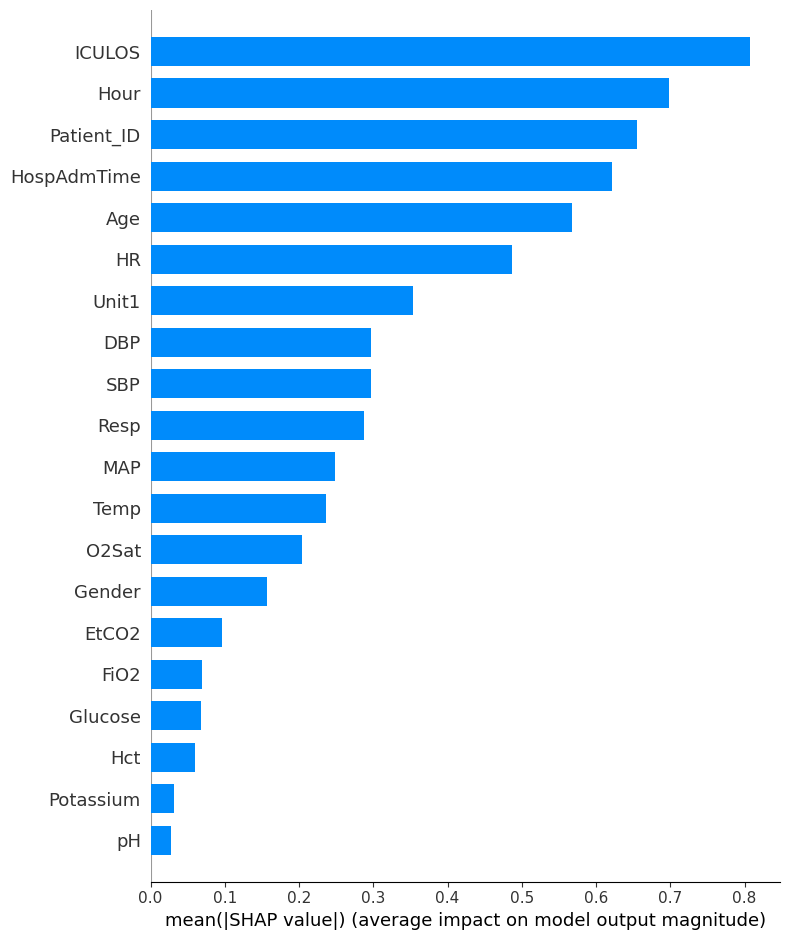

In [37]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model, X_train, X_test)

In [4]:
# aggregate_df.to_csv('complete_aggregate_df.csv', index=False)
data = pd.read_csv('complete_aggregate_df.csv')

In [4]:
data.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,1,0,1,0
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,2,0,1,0
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,3,0,1,0
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,NaN,83.14,0,NaN,NaN,-0.03,4,0,1,0
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,5,0,1,0


# modèle version 2

In [5]:
# Rééquilibrage pour l'augmentation du recall de la classe minoritaire '1'
# Création des ensembles d'entrainement et de test
df = data.drop(columns = ['will_have_sepsis', 'Unit1', 'Unit2'])
X_train, X_test, y_train, y_test = prepare_train_test(df, 'SepsisLabel')

X_train: (1241768, 40) X_test: (310442, 40) y_train: (1241768,) y_test: (310442,)


In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Configuration de l'imputeur pour remplacer les valeurs manquantes par la médiane de chaque colonne
imputer = SimpleImputer(strategy='median')

# Configuration de SMOTE
smote = SMOTE(random_state=42)

# Création d'un pipeline qui impute les valeurs manquantes puis applique SMOTE
pipeline = Pipeline([
    ('imputer', imputer),
    ('smote', smote)
])


# Application du pipeline sur les données d'entraînement
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Calcule des meilleurs hyperparamètres
best_params, study = perform_hyperparameter_optimization(X_train_resampled, y_train_resampled, objective, n_trials=100)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_v2.pkl'
save_study(study, study_filename)

# # Calcul du ratio pour 'scale_pos_weight'
# class_weights = compute_class_weight('balanced', classes=[0,1], y=y_train)
# scale_pos_weight = class_weights[0] / class_weights[1]



[I 2024-07-21 23:12:33,690] A new study created in memory with name: no-name-e402773b-40f1-427c-aac6-8f3caab9d4b1
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  

[I 2024-07-21 23:43:04,007] Trial 6 finished with value: 0.9431494913628032 and parameters: {'learning_rate': 0.31156763148163696, 'max_depth': 3, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 0.6189707918754463, 'subsample': 0.5002251410101575}. Best is trial 0 with value: 0.9881453295993635.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52: F

[I 2024-07-22 00:20:27,400] Trial 13 finished with value: 0.9776015121757207 and parameters: {'learning_rate': 0.27432116221591596, 'max_depth': 7, 'n_estimators': 208, 'min_child_weight': 3, 'gamma': 2.3488390422503334, 'subsample': 0.13758196993088495}. Best is trial 9 with value: 0.9884963118165379.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52:

[I 2024-07-22 00:53:30,251] Trial 20 finished with value: 0.985322300901647 and parameters: {'learning_rate': 0.7247260257550963, 'max_depth': 8, 'n_estimators': 113, 'min_child_weight': 1, 'gamma': 2.1866687934748055, 'subsample': 0.6559014493341175}. Best is trial 18 with value: 0.9914993419083428.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52: F

[I 2024-07-22 01:31:44,708] Trial 27 finished with value: 0.9917264962872151 and parameters: {'learning_rate': 0.7838674776932608, 'max_depth': 13, 'n_estimators': 183, 'min_child_weight': 2, 'gamma': 0.6090755780445536, 'subsample': 0.9685070691079588}. Best is trial 27 with value: 0.9917264962872151.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52:

[I 2024-07-22 02:15:32,948] Trial 34 finished with value: 0.9922578899244322 and parameters: {'learning_rate': 0.526581053204827, 'max_depth': 14, 'n_estimators': 177, 'min_child_weight': 4, 'gamma': 0.24087228925868479, 'subsample': 0.9521508116232963}. Best is trial 34 with value: 0.9922578899244322.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52:

[I 2024-07-22 02:57:44,316] Trial 41 finished with value: 0.9922566598465682 and parameters: {'learning_rate': 0.566634326690101, 'max_depth': 14, 'n_estimators': 183, 'min_child_weight': 4, 'gamma': 0.2275080441191373, 'subsample': 0.945174333505807}. Best is trial 34 with value: 0.9922578899244322.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52: F

[I 2024-07-22 03:39:38,767] Trial 48 finished with value: 0.988985472780427 and parameters: {'learning_rate': 0.4172118196768449, 'max_depth': 14, 'n_estimators': 169, 'min_child_weight': 7, 'gamma': 3.7724540063207503, 'subsample': 0.9182631245387863}. Best is trial 34 with value: 0.9922578899244322.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52: 

[I 2024-07-22 04:27:39,845] Trial 55 finished with value: 0.9909827092054929 and parameters: {'learning_rate': 0.2267219832176503, 'max_depth': 15, 'n_estimators': 153, 'min_child_weight': 5, 'gamma': 0.248009089390667, 'subsample': 0.9362196334921562}. Best is trial 34 with value: 0.9922578899244322.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52: 

[I 2024-07-22 05:07:35,353] Trial 62 finished with value: 0.9920278653638775 and parameters: {'learning_rate': 0.5847430750695273, 'max_depth': 15, 'n_estimators': 190, 'min_child_weight': 6, 'gamma': 0.3656788435552406, 'subsample': 0.8929839210793696}. Best is trial 34 with value: 0.9922578899244322.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52:

[I 2024-07-22 05:52:49,741] Trial 69 finished with value: 0.991703534833755 and parameters: {'learning_rate': 0.4926794001048915, 'max_depth': 15, 'n_estimators': 165, 'min_child_weight': 6, 'gamma': 0.7561115228705584, 'subsample': 0.7943617105919157}. Best is trial 34 with value: 0.9922578899244322.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52: 

[I 2024-07-22 06:48:42,378] Trial 76 finished with value: 0.9920413962203806 and parameters: {'learning_rate': 0.508513166367616, 'max_depth': 13, 'n_estimators': 187, 'min_child_weight': 4, 'gamma': 0.026017183118134585, 'subsample': 0.9699560707933552}. Best is trial 34 with value: 0.9922578899244322.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52

[I 2024-07-22 07:38:26,404] Trial 83 finished with value: 0.9924870944330776 and parameters: {'learning_rate': 0.5474239091197448, 'max_depth': 15, 'n_estimators': 194, 'min_child_weight': 4, 'gamma': 0.015241462299408343, 'subsample': 0.9020763309625207}. Best is trial 83 with value: 0.9924870944330776.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:5

[I 2024-07-22 08:30:01,168] Trial 90 finished with value: 0.9919950632875061 and parameters: {'learning_rate': 0.4050366199129988, 'max_depth': 14, 'n_estimators': 231, 'min_child_weight': 4, 'gamma': 0.4293044101039138, 'subsample': 0.9151118190411033}. Best is trial 83 with value: 0.9924870944330776.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_20156\233988270.py:52:

In [9]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_v2.joblib'
xgbc_model = train_and_save_xgboost_classifier(X_train_resampled, y_train_resampled, best_params, model_path)

In [ ]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model, X_test, y_test)
print(evaluation_report)

In [ ]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model, X_train, X_test)

# Entrainement du modèle sur un sous ensembles des données brutes

In [15]:
# Sous df en fonction des colonnes pertinentes
sub_columns = ['Hour',          'HR',       'O2Sat',        'Temp',
               'MAP',        'Resp',         'BUN',    'Chloride',
        'Creatinine',     'Glucose',         'Hct',         'Hgb',
               'WBC',   'Platelets',         'Age', 'HospAdmTime',
            'ICULOS', 'SepsisLabel']

sub_df_final = df_final[sub_columns]

In [ ]:
# Création des ensembles d'entrainement et de test
X = sub_df_final.drop(columns=['SepsisLabel'])
y = sub_df_final['SepsisLabel']

# Répartition des données
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2023)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [39]:
# Prédiction et évaluation
y_predicted = xgbc.predict(X_test)

# Affichage du rapport d'évaluation
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1886
           1       0.78      0.78      0.78      1887

    accuracy                           0.78      3773
   macro avg       0.78      0.78      0.78      3773
weighted avg       0.78      0.78      0.78      3773

